In [ ]:
# Original main() function - why it can't show beams
def main():
    config = OmegaConf.load("../configs/config.yaml")
    env = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(env, config)
    agents = experiment.agents

    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,
        env_dims=(config.world.height, config.world.width),
    )
    action_spec = ActionSpec(
        ["move_forward", "move_backward", "turn_left", "turn_right", "interact"]
    )

    # Create a custom HumanPlayer that works with StagHuntAgent
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size)
            # Calculate the expected visual size (without extra features)
            self.visual_size = (
                input_size[0]
                * input_size[1]
                * input_size[2]
                * (self.tile_size**2)
                * self.num_channels
            )
            # The StagHuntAgent will provide visual_size + 3 extra features
            self.total_input_size = self.visual_size + 3

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles StagHuntAgent's extra features."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                # Extract just the visual part (first visual_size elements)
                visual_state = state[:, : self.visual_size]

                # Reshape to image format
                visual_state = visual_state.reshape(
                    (
                        -1,
                        self.input_size[0] * self.tile_size,
                        self.input_size[1] * self.tile_size,
                        self.num_channels,
                    )
                )
                visual_state = np.array(visual_state, dtype=int)
                state_ = []
                for i in range(visual_state.shape[0]):
                    state_.append(visual_state[i, :, :, :])
                from sorrel.utils.visualization import plot

                plot(state_)

            # Get action from user
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=forward, s=backward, a=turn_left, d=turn_right, 4=interact): "
                )
                if action_ in ["w", "a", "s", "d"]:
                    if action_ == "w":
                        action = 0  # move_forward (relative to orientation)
                    elif action_ == "s":
                        action = 1  # move_backward (relative to orientation)
                    elif action_ == "a":
                        action = 2  # turn_left
                    elif action_ == "d":
                        action = 3  # turn_right
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print(np.concatenate((self.action_list, ["quit"])))

            return action

    # Create a custom StagHuntAgent that bypasses the memory stacking issue
    class StagHuntHumanAgent(StagHuntAgent):
        def get_action(self, state: np.ndarray) -> int:
            """Override get_action to bypass memory stacking for human player."""
            # For human player, we don't need memory stacking
            # Just pass the state directly to the model
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """Override add_memory to handle dimension mismatch for human player."""
            # For human player, we don't need to store experiences in memory
            # The human player doesn't learn from experience, so we can skip this
            pass

    human_player1 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            2,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    human_player2 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            2,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    agent1 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player1,
    )

    agent2 = StagHuntAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player2,
    )

    experiment.override_agents(agents=[agent1])  # Use single human agent
    experiment.run_experiment()

In [ ]:
# main_v2() - Fixed version that can show beams
def main_v2():
    config = OmegaConf.load("../configs/config.yaml")
    env = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(env, config)

    # FIX 1: Use HumanObservation with full_view=True (like cleanup game)
    from sorrel.models.human_player import HumanObservation

    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,  # Show entire world, not just vision radius
        env_dims=(config.world.height, config.world.width),
    )

    action_spec = ActionSpec(
        ["move_forward", "move_backward", "turn_left", "turn_right", "interact"]
    )

    # FIX 2: Custom HumanPlayer that handles RGB data correctly
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size, show=True)
            # FIX 3: No slicing needed for our data format
            self.SLICE = 0

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles RGB data correctly."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                print(f"Debug: state shape: {state.shape}")

                # FIX 4: Handle our RGB data format correctly
                if len(state.shape) == 2:
                    # Reshape flattened data back to image format
                    state = state.reshape(1, self.input_size[0], self.input_size[1], 4)

                print(f"Debug: reshaped state: {state.shape}")

                # FIX 5: Use proper layer compositing for visualization
                state_ = []
                for i in range(state.shape[0]):
                    state_.append(state[i, :, :, :])

                # Use our custom composited visualization
                plot_layers_composited(state_)

            # Get action from user
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=forward, s=backward, a=turn_left, d=turn_right, 4=interact): "
                )
                if action_ in ["w", "a", "s", "d"]:
                    if action_ == "w":
                        action = 0  # move_forward
                    elif action_ == "s":
                        action = 1  # move_backward
                    elif action_ == "a":
                        action = 2  # turn_left
                    elif action_ == "d":
                        action = 3  # turn_right
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print(np.concatenate((self.action_list, ["quit"])))

            return action

    # FIX 6: Custom StagHuntAgent that returns RGB data directly
    class StagHuntHumanAgent(StagHuntAgent):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.kind = "StagHuntAgent"

        def pov(self, world: StagHuntWorld) -> np.ndarray:
            """FIX 7: Return RGB data directly from render_sprite."""
            from sorrel.utils.visualization import render_sprite

            sprite_layers = render_sprite(
                world=world,
                location=self.location,
                vision=None,  # Full view
            )

            # FIX 8: Composite all layers properly
            if len(sprite_layers) == 1:
                obs = sprite_layers[0]
            else:
                # Composite all layers with alpha blending
                obs = sprite_layers[0].copy()
                for layer in sprite_layers[1:]:
                    alpha = layer[:, :, 3] / 255.0
                    for c in range(3):
                        obs[:, :, c] = (1 - alpha) * obs[:, :, c] + alpha * layer[
                            :, :, c
                        ]
                    obs[:, :, 3] = np.maximum(obs[:, :, 3], layer[:, :, 3])

            return obs.reshape(1, -1)

        def get_action(self, state: np.ndarray) -> int:
            """FIX 9: No memory stacking for human player."""
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """FIX 10: No memory needed for human player."""
            pass

    # FIX 11: Use correct input size for 3 layers
    human_player = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            3,
        ),  # 3 layers: terrain, dynamic, beam
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    # FIX 12: Create agents with proper observation spec
    agent1 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
    )

    agent2 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
    )

    experiment.override_agents(agents=[agent1, agent2])
    experiment.run_experiment()

In [ ]:
# Test main_v2() - should show beams properly
main_v2()

In [11]:
# Simplified version based on cleanup game approach
def main_cleanup_style():
    config = OmegaConf.load("../configs/config.yaml")
    env = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(env, config)

    # Use HumanObservation with full_view like cleanup game
    from sorrel.models.human_player import HumanObservation

    # Create observation spec that works like cleanup game
    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,  # Show entire world like cleanup
        env_dims=(config.world.height, config.world.width),  # Full world dimensions
    )

    action_spec = ActionSpec(
        ["move_forward", "move_backward", "turn_left", "turn_right", "interact"]
    )

    # Create a custom HumanPlayer that handles our data format correctly
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size, show=True)
            # Override the SLICE calculation for our use case
            self.SLICE = 0  # No slicing needed for our data format

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles our data format correctly."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                print(f"Debug: state shape: {state.shape}")
                print(f"Debug: SLICE: {self.SLICE}")

                # Our data is already in the correct format, no reshaping needed
                if self.SLICE > 0:
                    state = state[:, self.SLICE :]

                print(f"Debug: after slicing: {state.shape}")

                # Reshape to image format for visualization
                # Our data is (height, width, channels) already
                if (
                    len(state.shape) == 2
                    and state.shape[1] == config.world.height * config.world.width * 4
                ):
                    # Flattened data, reshape it
                    state = state.reshape(1, config.world.height, config.world.width, 4)
                elif len(state.shape) == 2:
                    # Try to reshape based on input_size
                    state = state.reshape(1, self.input_size[0], self.input_size[1], 4)

                print(f"Debug: final state shape: {state.shape}")

                # Convert to list format for plot function
                state_ = []
                for i in range(state.shape[0]):
                    state_.append(state[i, :, :, :])

                # Use our custom plot function
                plot_layers_composited(state_)

            # Get action from user
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=forward, s=backward, a=turn_left, d=turn_right, 4=interact): "
                )
                if action_ in ["w", "a", "s", "d"]:
                    if action_ == "w":
                        action = 0  # move_forward
                    elif action_ == "s":
                        action = 1  # move_backward
                    elif action_ == "a":
                        action = 2  # turn_left
                    elif action_ == "d":
                        action = 3  # turn_right
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print(np.concatenate((self.action_list, ["quit"])))

            return action

    # Create human player with custom visualization
    human_player = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            3,
        ),  # height, width, layers
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    # Create a custom StagHuntAgent that works with HumanPlayer
    class StagHuntHumanAgent(StagHuntAgent):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # Override the kind to match the entity list
            self.kind = "StagHuntAgent"

        def pov(self, world: StagHuntWorld) -> np.ndarray:
            """Return the raw visual observation for HumanPlayer."""
            # Get the raw visual observation directly from render_sprite
            from sorrel.utils.visualization import render_sprite

            sprite_layers = render_sprite(
                world=world,
                location=self.location,
                vision=None,  # Full view
            )
            print(f"Debug: sprite_layers is list with {len(sprite_layers)} layers")
            for i, layer in enumerate(sprite_layers):
                print(f"Debug: layer {i} shape: {layer.shape}")

            # Convert list of layers to single array for HumanPlayer
            # HumanPlayer expects a single flattened array
            if len(sprite_layers) == 1:
                obs = sprite_layers[0]
            else:
                # Composite all layers into one
                obs = sprite_layers[0].copy()
                for layer in sprite_layers[1:]:
                    # Simple alpha blending
                    alpha = layer[:, :, 3] / 255.0
                    for c in range(3):
                        obs[:, :, c] = (1 - alpha) * obs[:, :, c] + alpha * layer[
                            :, :, c
                        ]
                    obs[:, :, 3] = np.maximum(obs[:, :, 3], layer[:, :, 3])

            print(f"Debug: final obs shape: {obs.shape}")
            return obs.reshape(1, -1)

        def get_action(self, state: np.ndarray) -> int:
            """Override get_action to work with HumanPlayer."""
            # HumanPlayer expects the state directly, no memory stacking needed
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """Override add_memory to handle HumanPlayer."""
            # HumanPlayer doesn't need memory for learning
            pass

    # Create agent with the same observation spec
    agent1 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
    )

    agent2 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
    )

    experiment.override_agents(agents=[agent1, agent2])
    experiment.run_experiment()

In [12]:
# Test the fixed cleanup-style approach with custom HumanPlayer
main_cleanup_style()

Debug: state shape: (1, 123904)
Debug: SLICE: 0
Debug: after slicing: (1, 123904)


ValueError: cannot reshape array of size 123904 into shape (1,11,11,4)

In [1]:
import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf

# sorrel imports
from sorrel.examples.staghunt.agents import StagHuntAgent
from sorrel.examples.staghunt.entities import Empty, entity_list
from sorrel.examples.staghunt.env import StagHuntEnv
from sorrel.examples.staghunt.world import StagHuntWorld
from sorrel.action.action_spec import ActionSpec
from sorrel.models.human_player import HumanPlayer, HumanObservation

### Human player test for the model

In [2]:
def main():
    config = OmegaConf.load("../configs/config.yaml")
    env = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(env, config)
    agents = experiment.agents

    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,
        env_dims=(config.world.height, config.world.width),
    )
    action_spec = ActionSpec(
        ["move_forward", "move_backward", "turn_left", "turn_right", "interact"]
    )

    # Create a custom HumanPlayer that works with StagHuntAgent
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size)
            # Calculate the expected visual size (without extra features)
            self.visual_size = (
                input_size[0]
                * input_size[1]
                * input_size[2]
                * (self.tile_size**2)
                * self.num_channels
            )
            # The StagHuntAgent will provide visual_size + 3 extra features
            self.total_input_size = self.visual_size + 3

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles StagHuntAgent's extra features."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                # Extract just the visual part (first visual_size elements)
                visual_state = state[:, : self.visual_size]

                # Reshape to image format
                visual_state = visual_state.reshape(
                    (
                        -1,
                        self.input_size[0] * self.tile_size,
                        self.input_size[1] * self.tile_size,
                        self.num_channels,
                    )
                )
                visual_state = np.array(visual_state, dtype=int)
                state_ = []
                for i in range(visual_state.shape[0]):
                    state_.append(visual_state[i, :, :, :])
                from sorrel.utils.visualization import plot

                plot(state_)

            # Get action from user
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=forward, s=backward, a=turn_left, d=turn_right, 4=interact): "
                )
                if action_ in ["w", "a", "s", "d"]:
                    if action_ == "w":
                        action = 0  # move_forward (relative to orientation)
                    elif action_ == "s":
                        action = 1  # move_backward (relative to orientation)
                    elif action_ == "a":
                        action = 2  # turn_left
                    elif action_ == "d":
                        action = 3  # turn_right
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print(np.concatenate((self.action_list, ["quit"])))

            return action

    # Create a custom StagHuntAgent that bypasses the memory stacking issue
    class StagHuntHumanAgent(StagHuntAgent):
        def get_action(self, state: np.ndarray) -> int:
            """Override get_action to bypass memory stacking for human player."""
            # For human player, we don't need memory stacking
            # Just pass the state directly to the model
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """Override add_memory to handle dimension mismatch for human player."""
            # For human player, we don't need to store experiences in memory
            # The human player doesn't learn from experience, so we can skip this
            pass

    human_player1 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            2,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    human_player2 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            2,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    agent1 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player1,
    )

    agent2 = StagHuntAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player2,
    )

    experiment.override_agents(agents=[agent1])  # Use single human agent
    experiment.run_experiment()

### Turn taking loop
Choose an action from [0, 1, 2, 3, 4, 5] to act on the environment.

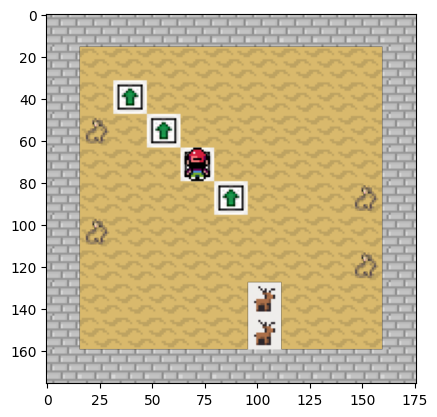

KeyboardInterrupt: Quitting...

In [7]:
main()